This tutorial reproduces the results of Tutorial 14 on spinw.org. It is the spin wave dispersion of YVO3. The original results can be accessed at "http://prl.aps.org/abstract/PRL/v91/i25/e257202". In this tutorial, the system is set up in a pseudocubic unit cell, doubled along c-axis.

Get Packages

In [7]:
using Sunny,GLMakie,CairoMakie

Define the lattice. Set up the lattice, the position of magnetic atoms, the symmetry inequivalent postions and the spin. The space group is P-1 or 2. Note that there are two inequivalent Vanadium atom positions. Sunny uses the space group symmetry to produce all equivalent sites. The supercell is (2,2,1)

In [8]:
a = 5.2821/sqrt(2);
b = 5.6144/sqrt(2);
c = 7.5283;

latvecs = lattice_vectors(a, b, c, 90, 90, 90)
positions=[[0, 0, 0],[0,0,1/2]]
V = Crystal(latvecs,positions,1)
GLMakie.activate!()
view_crystal(V)
print_symmetry_table(V,8)
sys=System(V, (2,2,1),[SpinInfo(1,S=1/2,g=2),SpinInfo(2,S=1/2,g=2)], :dipole, seed=0)

Atom 1
Position [0, 0, 0], multiplicity 1
Allowed g-tensor: [  A F+I E-H
                   F-I   B D+G
                   E+H D-G   C]
Allowed anisotropy in Stevens operators:
    c₁*𝒪[2,-2] + c₂*𝒪[2,-1] + c₃*𝒪[2,0] + c₄*𝒪[2,1] + c₅*𝒪[2,2] +
    c₆*𝒪[4,-4] + c₇*𝒪[4,-3] + c₈*𝒪[4,-2] + c₉*𝒪[4,-1] + c₁₀*𝒪[4,0] + c₁₁*𝒪[4,1] + c₁₂*𝒪[4,2] + c₁₃*𝒪[4,3] + c₁₄*𝒪[4,4] +
    c₁₅*𝒪[6,-6] + c₁₆*𝒪[6,-5] + c₁₇*𝒪[6,-4] + c₁₈*𝒪[6,-3] + c₁₉*𝒪[6,-2] + c₂₀*𝒪[6,-1] + c₂₁*𝒪[6,0] + c₂₂*𝒪[6,1] + c₂₃*𝒪[6,2] + c₂₄*𝒪[6,3] + c₂₅*𝒪[6,4] + c₂₆*𝒪[6,5] + c₂₇*𝒪[6,6]

Atom 2
Position [0, 0, 1/2], multiplicity 1
Allowed g-tensor: [  A F+I E-H
                   F-I   B D+G
                   E+H D-G   C]
Allowed anisotropy in Stevens operators:
    c₁*𝒪[2,-2] + c₂*𝒪[2,-1] + c₃*𝒪[2,0] + c₄*𝒪[2,1] + c₅*𝒪[2,2] +
    c₆*𝒪[4,-4] + c₇*𝒪[4,-3] + c₈*𝒪[4,-2] + c₉*𝒪[4,-1] + c₁₀*𝒪[4,0] + c₁₁*𝒪[4,1] + c₁₂*𝒪[4,2] + c₁₃*𝒪[4,3] + c₁₄*𝒪[4,4] +
    c₁₅*𝒪[6,-6] + c₁₆*𝒪[6,-5] + c₁₇*𝒪[6,-4] + c₁₈*𝒪[6,-3] + c₁₉*𝒪[6,-2] + c₂₀*𝒪[6,-1] + c₂₁*

System [Dipole mode]
Lattice (2×2×1)×2
Energy per site 0


Set up the exchanges with the values obtained from the paper. Theta is the canting angle in the ac-plane. There is also easy plane anisotropy.

In [9]:
Jab   = 2.6;
Jc    = 3.1;
delta = 0.35;
K1    = 0.90;
K2    = 0.97;
d     = 1.15;

theta = 1/2*atan(2*d/(2*Jc-K1-K2))

Jc1=[-Jc*(1+delta)+K2 0 -d;0 -Jc*(1+delta) 0; +d 0 -Jc*(1+delta)]
Jc2=[-Jc*(1-delta)+K2 0 d;0 -Jc*(1-delta) 0; -d 0 -Jc*(1-delta)]

set_exchange!(sys,Jab,Bond(1, 1, [1, 0, 0]))
set_exchange!(sys,Jab,Bond(2, 2, [1, 0, 0]))
set_exchange!(sys,Jc1,Bond(1, 2, [0, 0, 0]))
set_exchange!(sys,Jc2,Bond(2, 1, [0, 0, 1]))
set_exchange!(sys,Jab,Bond(1, 1, [0, 1, 0]))
set_exchange!(sys,Jab,Bond(2, 2, [0, 1, 0]))
#S=spin_matrices(1/2)
set_onsite_coupling!(sys, S -> -K1*S[1]^2, 1)
set_onsite_coupling!(sys, S -> -K1*S[1]^2, 2)
randomize_spins!(sys)
minimize_energy!(sys)
plot_spins(sys)

Create the LSWT object and set up a path. Obtain the dispersion and intensity bands.

In [22]:
q_points=[[0.75,0.75,0],[0.5,0.5,0],[0.5,0.5,1]]
density = 200
path, xticks = reciprocal_space_path(V, q_points, density);
swt=SpinWaveTheory(sys)
formula = intensity_formula(swt, :perp; kernel=delta_function_kernel)
disp, intensity = intensities_bands(swt, path, formula);

Plot the dispersion and convoluted spectra

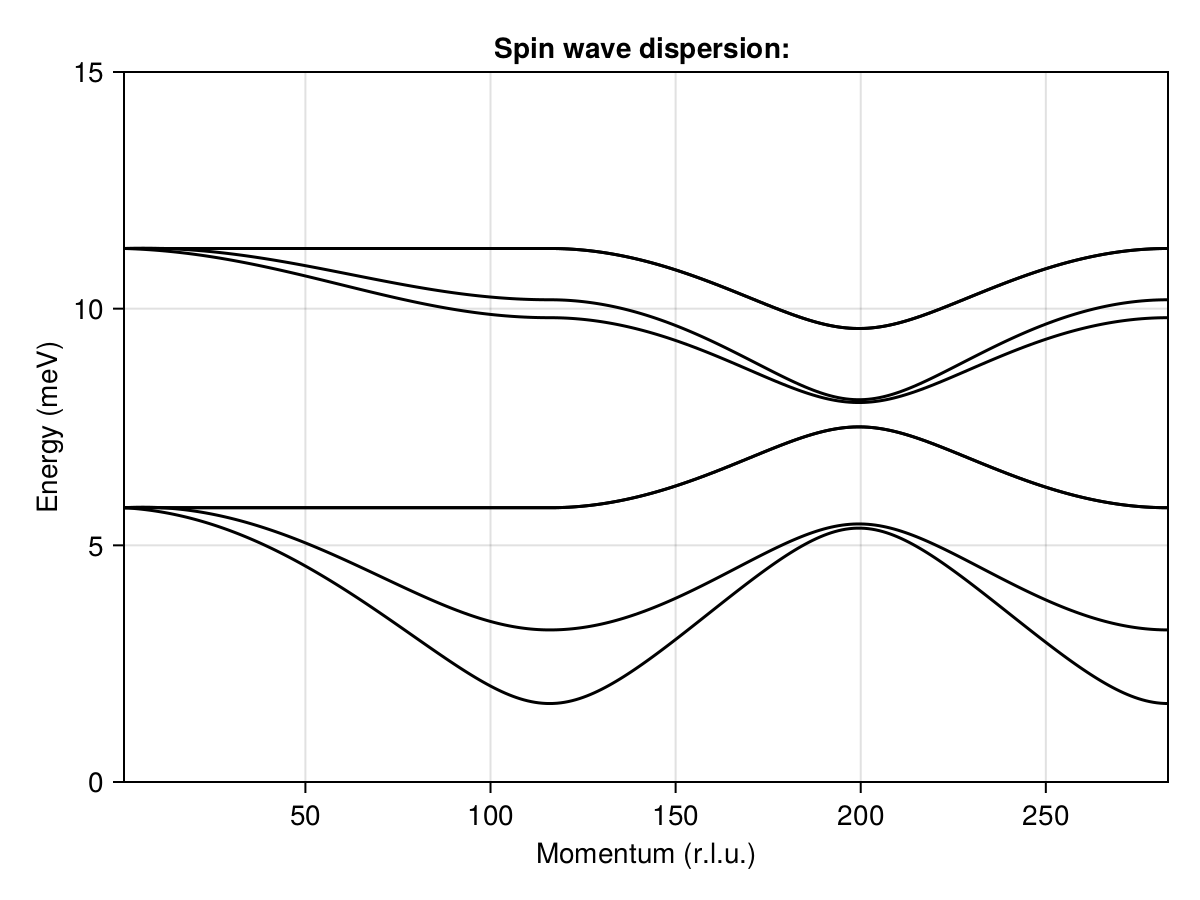

In [23]:
CairoMakie.activate!()
fig = Figure()
ax = Axis(fig[1,1]; xlabel="Momentum (r.l.u.)", ylabel="Energy (meV)",title="Spin wave dispersion: ")
ylims!(ax, 0, 15)
xlims!(ax, 1, size(disp, 1))
colorrange = extrema(intensity)
for i in axes(disp)[2]
    lines!(ax, 1:length(disp[:,i]), disp[:,i]; color="black")
end
fig

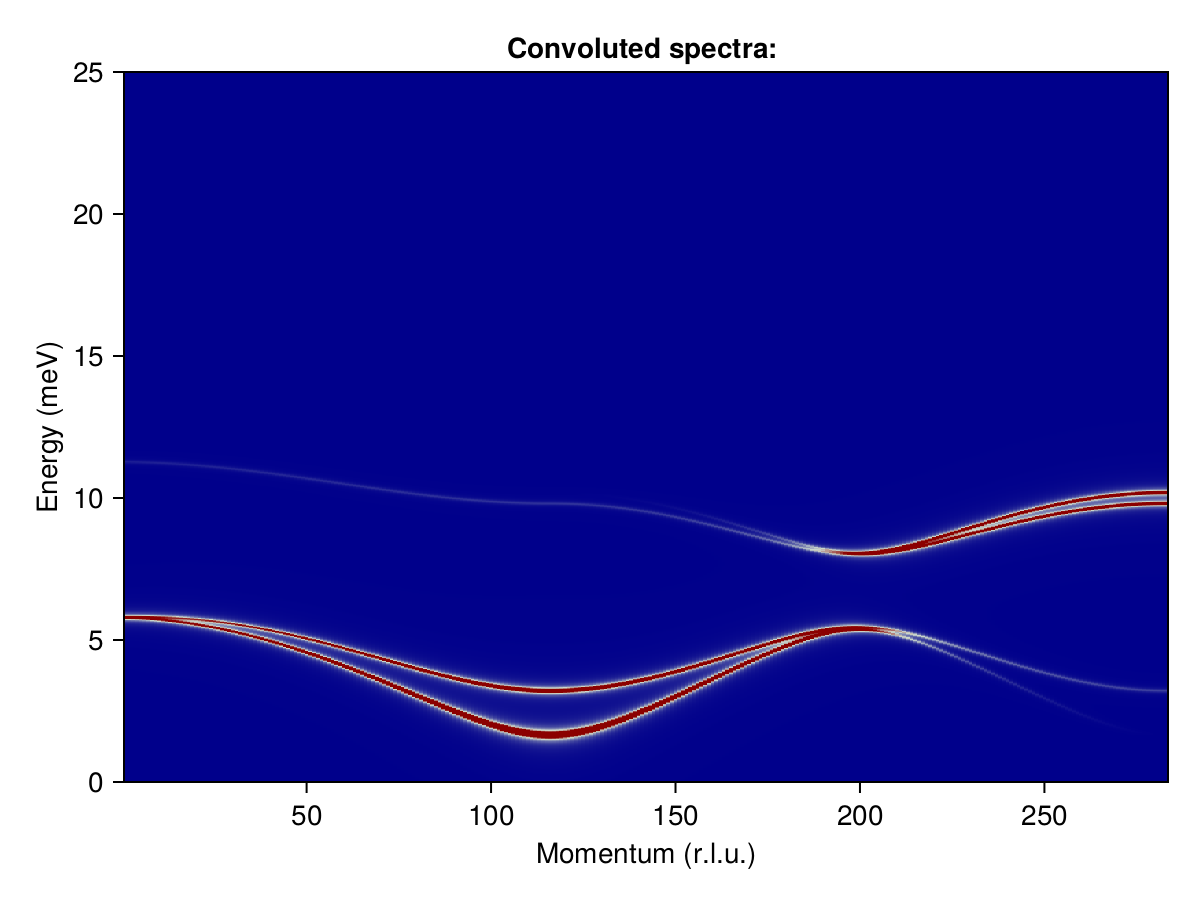

In [30]:
γ = 0.05
broadened_formula = intensity_formula(swt, :perp; kernel=lorentzian(γ))
energies = collect(0:0.02:125) 
is = intensities_broadened(swt, path, energies, broadened_formula);
fig = Figure()
ax = Axis(fig[1,1]; xlabel="Momentum (r.l.u.)", ylabel="Energy (meV)",title="Convoluted spectra: ")
ylims!(ax, 0.0, 25.0)
pl=heatmap!(ax, 1:size(is, 1), energies, real(is),colorrange=(0,1))
pl.colormap = Reverse(:redsblues)
fig